# 23. Convolutional AutoEncoder

### Street View House Numbers (SVHN) Dataset

10 classes: 0 ~ 9. 32 * 32 image.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                        split='train',
                        transform=transforms.ToTensor(),
                        download=True)

svhn_test = dsets.SVHN(root='data/',
                       split='test',
                       transform=transforms.ToTensor(),
                       download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
print(len(svhn_train), len(svhn_test))

73257 26032


In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = svhn_train,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = svhn_test,
                                          batch_size = 1,
                                          shuffle = False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

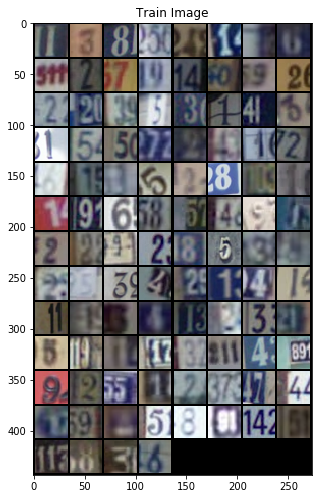

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [8]:
# N: input, F: filter, P: padding, S: stride

def c_conv(N, F, P=0, S=1):
    return int((N+2*P-F)/S+1)

def c_pool(N, F):
    return int(N/F)

# Transposed convolution
def t_conv(N, F, P=0, S=1):
    return int(S*(N-1)+F-2*P)

In [9]:
# Encoder
c0 = 32
c1 = c_conv(c0, 5)
c2 = c_conv(c1, 5)
c3 = c_pool(c2, 2)
c4 = c_conv(c3, 5)
c5 = c_pool(c4, 2)

print(c1, c2, c3, c4, c5)

28 24 12 8 4


In [10]:
# Decoder
c0 = 4
c1 = t_conv(c0, 4, 1, 2)
c2 = t_conv(c1, 4, 1, 2)
c3 = t_conv(c2, 4, 1, 2)

print(c1, c2, c3)

8 16 32


In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),         # 3 = color
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
    def forward(self, x):
        z = self.encoder(x)    # 데이터의 종류가 다양해졌기 때문에 z의 공간을 늘려준다.
        
        return z

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
#             nn.MaxUnpool2d(2,2),
            
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
#             nn.MaxUnpool2d(2,2),
            
            nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,3,32,32)
        
        return out

In [13]:
E = Encoder().cuda()
D = Decoder().cuda()

## Training

In [14]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [18]:
num_epochs = 50

for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        pred = D(E(X))
        cost = loss(pred, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/50], lter [732/732] Loss: 0.0046
Epoch [2/50], lter [732/732] Loss: 0.0033
Epoch [3/50], lter [732/732] Loss: 0.0032
Epoch [4/50], lter [732/732] Loss: 0.0031
Epoch [5/50], lter [732/732] Loss: 0.0039
Epoch [6/50], lter [732/732] Loss: 0.0032
Epoch [7/50], lter [732/732] Loss: 0.0041
Epoch [8/50], lter [732/732] Loss: 0.0035
Epoch [9/50], lter [732/732] Loss: 0.0035
Epoch [10/50], lter [732/732] Loss: 0.0034
Epoch [11/50], lter [732/732] Loss: 0.0035
Epoch [12/50], lter [732/732] Loss: 0.0043
Epoch [13/50], lter [732/732] Loss: 0.0047
Epoch [14/50], lter [732/732] Loss: 0.0031
Epoch [15/50], lter [732/732] Loss: 0.0036
Epoch [16/50], lter [732/732] Loss: 0.0032
Epoch [17/50], lter [732/732] Loss: 0.0030
Epoch [18/50], lter [732/732] Loss: 0.0031
Epoch [19/50], lter [732/732] Loss: 0.0034
Epoch [20/50], lter [732/732] Loss: 0.0034
Epoch [21/50], lter [732/732] Loss: 0.0034
Epoch [22/50], lter [732/732] Loss: 0.0033
Epoch [23/50], lter [732/732] Loss: 0.0029
Epoch [24/50], lter 

## Test

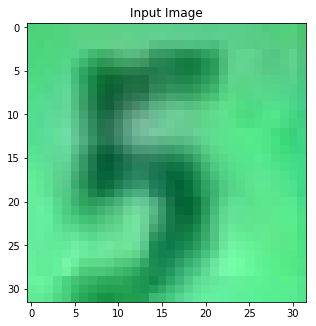

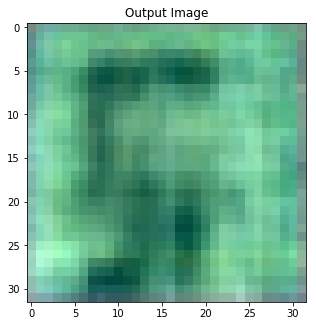

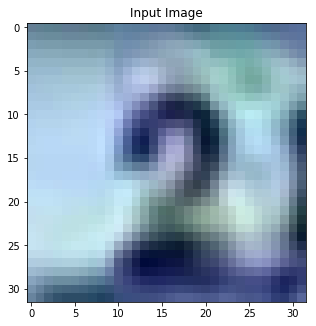

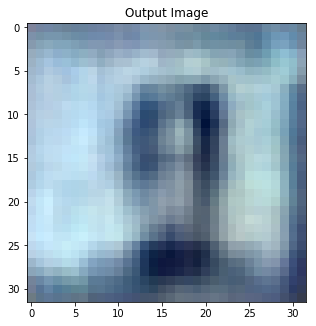

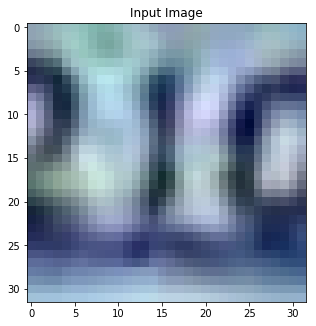

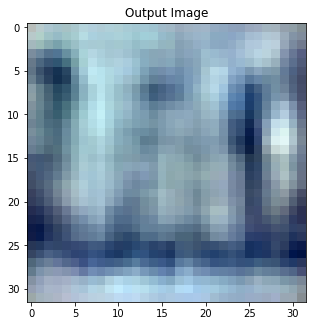

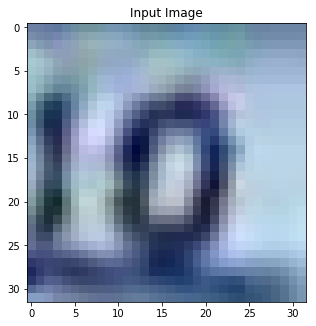

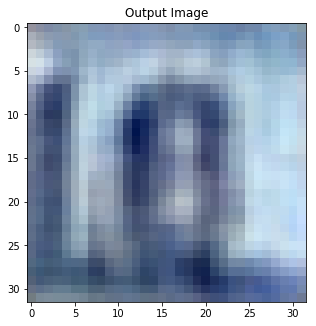

In [19]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    images = images.view(-1, 3, 32, 32).cuda()
    
    outputs = D(E(images))
    outputs = outputs.view(-1, 3, 32, 32)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break